In [1]:
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import numpy as np
import random
# from matplotlib.patches import Polygon
from shapely.geometry import Polygon

class BoxToPolygonEnv(gym.Env):
    def __init__(self):
        super(BoxToPolygonEnv, self).__init__()

        # Define action and observation spaces
        self.action_space = spaces.Discrete(4)  # Four discrete actions (move in four directions)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)  # 2D state space

        # Initialize the environment
        self.polygon = self.generate_random_polygon()
        self.goal = self.calculate_polygon_center()

        # Initialize the agent's position
        self.agent_position1 = self.calculate_polygon_center()
        self.agent_position2 = self.calculate_polygon_center()
        self.box1 = self.generate_random_box(0.0,0.0)
        self.box2 = self.generate_random_box(0.0,0.0)

    def reset(self, seed = 0):
        # Reset the environment
        self.polygon = self.generate_random_polygon()
    
        self.goal = self.calculate_polygon_center()
        self.agent_position1 = self.calculate_polygon_center()
        self.agent_position2 = self.calculate_polygon_center()
        self.box1 = self.generate_random_box(0.0,0.0)
        self.box2 = self.generate_random_box(0.0,0.0)
        return np.concatenate((self.agent_position1, self.agent_position2))

    def step(self, action, agent= np.random.randint(1,3)):
        # Take a step in the environment based on the chosen action
        if agent == 1:
            if action == 0:  # Move up
                self.agent_position1[1] += 0.00001
            elif action == 1:  # Move down
                self.agent_position1[1] -= 0.00001
            elif action == 2:  # Mo1ve left
                self.agent_position1[0] -= 0.00001
            elif action == 3:  # Mo1ve right
                self.agent_position1[0] += 0.00001
        else:
            if action == 0:  # Move up
                self.agent_position2[1] += 0.00001
            elif action == 1:  # Mo2ve down
                self.agent_position2[1] -= 0.00001
            elif action == 2:  # Mo2ve left
                self.agent_position2[0] -= 0.00001
            elif action == 3:  # Mo2ve right
                self.agent_position2[0] += 0.00001

        # Calculate reward
        
        self.box1 = self.generate_random_box(self.agent_position1[0],self.agent_position1[1])
        self.box2 = self.generate_random_box(self.agent_position2[0],self.agent_position2[1])
        # distance_to_goal = np.linalg.norm(self.agent_position - self.goal)
        if self.box1.intersects(self.box2):
            reward = -1
            done = False
        else:
            reward = 1
            done = True # Terminate if the agent is close to the goal

        return np.concatenate((self.agent_position1,self.agent_position2)), reward, done, {}

    def render(self, mode='human'):
        # Visualization (you can implement a custom visualization method here)
        pass

    def generate_random_polygon(self):
        #create a polygon 
        polygon = Polygon([(103.9174818, 1.3099216), (103.9182225, 1.3082086), (103.9184369, 1.3076434), (103.9194155, 1.3077896), (103.9188552,1.3094494), (103.9180992 ,1.3094457), (103.9178489, 1.3100437), (103.9174818, 1.3099216)])
        return polygon 
        
    # def generate_random_box(self,x, y, width=0.0001, height=0.0001):
    #     #generate random polygon 
        
    #     return Polygon([(x, y), (x + width, y), (x + width, y + height), (x, y + height)])
    
    def generate_random_box(self, x,y):
        num_vertices = random.randint(5, 10)
        
        vertices = [(x + random.uniform(-0.0001, +0.0001), y+ random.uniform(-0.0001, +0.0001)) for _ in range(num_vertices)]
        #generate Polygon with x,y width and height
        
        return Polygon(vertices)


    def calculate_polygon_center(self):
        polygon = self.polygon
        vertices = polygon.exterior.coords[:-1]
        num_vertices = len(vertices)
        sum_x = sum(vertex[0] for vertex in vertices)
        sum_y = sum(vertex[1] for vertex in vertices)
    
        center_x = sum_x / num_vertices
        center_y = sum_y / num_vertices
    
        return np.array([center_x, center_y])
    
        #check if point is inside the polygon (offset 0.01 inside the polygon)
        #check 
    
    
# Example usage of the custom environment
env = BoxToPolygonEnv()
obs = env.reset()




In [12]:
model = PPO('MlpPolicy', env, verbose=1)
# Train the agent
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.1     |
|    ep_rew_mean     | -24.1    |
| time/              |          |
|    fps             | 5515     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 23.6        |
|    ep_rew_mean          | -21.6       |
| time/                   |             |
|    fps                  | 3818        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009549165 |
|    clip_fraction        | 0.0264      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0           |
|    learning_rate        | 0.

In [13]:
model_name = "ppo-SSA"
model.save(model_name)

In [2]:
model = PPO.load("ppo-SSA.zip")

In [3]:
obs = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, _, done, _ = env.step(action)
    print(action)
    if done:
        obs = env.reset()
        print('done')

1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
done
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
done
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
done
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
done
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1

Test 2
box placement
Generate buildings that does not intersect


In [130]:
import gym
from gym import spaces
import numpy as np
import math

class ContinuousBoxPlacementEnv(gym.Env):
    def __init__(self, grid_size=(10, 10), max_boxes=5):
        super(ContinuousBoxPlacementEnv, self).__init__()
        self.grid_size = grid_size
        self.grid= np.zeros(self.grid_size, dtype=int)
        self.max_boxes = max_boxes

        # Define the action space for continuous placement (x, y, length, width, height)
        self.action_space = spaces.Box(low=np.array([0,0,1,1,1]), high=np.array([1,1,2,2,9]), shape=(5,))

        # Define the state space to represent the current box positions and sizes
        self.observation_space = spaces.MultiBinary(np.prod(grid_size) + max_boxes )

        self.boxes_placed = 0
        self.boxes = np.zeros((max_boxes, 5), dtype=float)
        self.state = self._get_state()

    def reset(self):
        self.boxes_placed = 0
        self.boxes = np.zeros((self.max_boxes, 5), dtype=float)
        self.state = self._get_state()
        self.grid = np.zeros(self.grid_size)
        flat_grid = self.grid.flatten()
        box_count = np.zeros(self.max_boxes)
        self.state = np.concatenate([flat_grid, box_count])
        return self.state

    def step(self, action):
        # Execute an action (place a box) and return the next state, reward, and done flag
        if self.boxes_placed >= self.max_boxes:
            return self.state, 0, True, {}

        x, y, length, width, height = action
        x, y, length, width, height  = math.floor(x*9.8), math.floor(y*9.8), length, width, height

        if not self._is_valid_placement(x, y, length, width, height):
            return self.state, -1, False, {}

        self.boxes[self.boxes_placed] = [x, y, length, width, height]
        self.boxes_placed += 1
        self.grid[x,y] = 1 
        self.state = self._get_state()

        reward = 1

        done = self.boxes_placed >= self.max_boxes

        return self.state, reward, done, {}

    def _is_valid_placement(self, x, y, length, width, height):
        # Check if the placement is valid (no intersection with other boxes)
        
        for i in range(self.boxes_placed):
            box = self.boxes[i]
            if (x < box[0] + box[2] and x + length > box[0] and
                y < box[1] + box[3] and y + width > box[1]):
                print(box, ' compare with')
                print(x,y,length,width,height)
                return False

        return True

    def _get_state(self):
        flat_grid = self.grid.flatten()
        
        box_count = np.zeros(self.max_boxes)
        box_count[:self.boxes_placed] = 1
        return np.concatenate([flat_grid, box_count])

# Example usage:
env = ContinuousBoxPlacementEnv()
obs = env.reset()

# Sample action: (x, y, length, width, height)
action = np.array([0.5, 0.4, 0.3, 0.2, 0.1])
obs, reward, done, _ = env.step(action)
print("Next state (box placement):")
print(obs)


Next state (box placement):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [131]:
model = PPO('MlpPolicy', env, verbose=1)
# Train the agent
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[0. 5. 1. 1. 1.]  compare with
0 5 1.0 1.4773626 1.0
[0.         0.         1.         1.         1.51752496]  compare with
0 0 1.0 1.0 1.0
[0. 0. 1. 1. 1.]  compare with
0 0 1.0 1.0 1.0
[0. 9. 1. 1. 1.]  compare with
0 9 1.0728651 1.1601332 1.237359
[0. 0. 1. 1. 1.]  compare with
0 0 1.0 1.0 1.0
[0. 6. 1. 1. 1.]  compare with
0 6 1.0 1.0 1.283002
[0. 6. 1. 1. 1.]  compare with
0 6 1.0 1.0 1.0
[0. 0. 1. 1. 1.]  compare with
0 0 1.0 1.3694153 1.0
[0. 3. 1. 1. 1.]  compare with
0 3 1.0 1.0 1.0
[0. 0. 1. 1. 1.]  compare with
0 0 1.0 1.0 1.0
[0.         0.         1.         1.37805712 1.        ]  compare with
0 0 1.0 2.0 1.0
[0.         0.         1.         1.37805712 1.        ]  compare with
0 0 2.0 1.0 1.0
[0.         0.         1.         1.37805712 1.        ]  compare with
0 0 1.0 1.0 1.0
[9. 0. 1. 1. 1.]  compare with
9 0 1.0 1.0 1.0
[0.         0.         1.         1.37805712 1.       

In [163]:
obs = env.reset()
while True:
# for _ in range(1000):
    action, _ = model.predict(obs)
    
    obs, _, done, _ = env.step(action)
    #reshpare a list to np.array (10x10)
    if done:

        print(np.array(obs[:-5]).reshape(10,10))
        print('boxes placed:\n ',env.boxes)
        # obs = env.reset()
        print('done')
        break



[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
boxes placed:
  [[4.         7.         1.         1.         1.        ]
 [1.         0.         1.         1.         2.35483479]
 [3.         7.         1.         1.         1.        ]
 [3.         0.         1.         1.         1.        ]
 [9.         3.         1.         1.         1.        ]]
done


AttributeError: 'BoxToPolygonEnv' object has no attribute 'boxes'

/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Matplotli

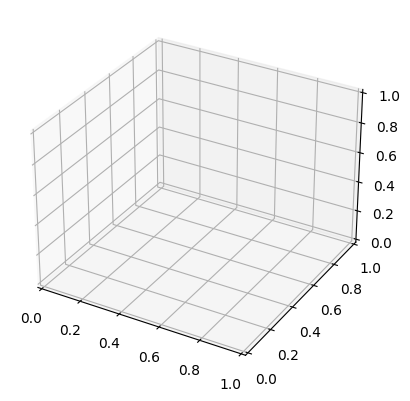

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from mpl_toolkits.mplot3d import Axes3D
import numpy as np



# Create a Matplotlib 3D figure

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create vertices for the building
for i in range(len(env.boxes)):
    x = env.boxes[i][0]
    y = env.boxes[i][1]
    length = env.boxes[i][2]
    width = env.boxes[i][3]
    height = env.boxes[i][4]

    vertices = np.array([
        [x, y, 0],
        [x, y + width, 0],
        [x + length, y + width, 0],
        [x + length, y, 0],
        [x, y, height],
        [x, y + width, height],
        [x + length, y + width, height],
        [x + length, y, height]
    ])

    # Define faces of the building
    faces = [
        [vertices[0], vertices[1], vertices[5], vertices[4]],
        [vertices[7], vertices[6], vertices[2], vertices[3]],
        [vertices[0], vertices[4], vertices[7], vertices[3]],
        [vertices[1], vertices[5], vertices[6], vertices[2]],
        [vertices[4], vertices[5], vertices[6], vertices[7]]
    ]

    # Plot the building
    ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Set plot limits
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_zlim([0, 10])

# Display the plot
plt.show()


Test 3 Generate building with Plot ratio 

In [12]:
import gym
from gym import spaces
import numpy as np
import math
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class ContinuousBoxPlacementEnv(gym.Env):
    def __init__(self, grid_size=(10, 10), max_boxes=100, plot_ratio= 0.5):
        super(ContinuousBoxPlacementEnv, self).__init__()
        self.grid_size = grid_size
        self.grid= np.zeros(self.grid_size, dtype=int)
        self.max_boxes = max_boxes
        self.plot_ratio = plot_ratio

        # Define the action space for continuous placement (x, y, length, width, height)
        self.action_space = spaces.Box(low=np.array([0,0,2,2,1]), high=np.array([1,1,5,5,9]), shape=(5,))

        # Define the state space to represent the current box positions and sizes
        self.observation_space = spaces.MultiBinary(np.prod(grid_size) + max_boxes )

        self.boxes_placed = 0
        self.boxes = np.zeros((1,5), dtype=float)
        self.state = self._get_state()

    def reset(self):
        self.boxes_placed = 0
        self.boxes = np.zeros((1,5), dtype=float)
        self.state = self._get_state()
        self.grid = np.zeros(self.grid_size)
        flat_grid = self.grid.flatten()
        box_count = np.zeros(self.max_boxes)
        self.state = np.concatenate([flat_grid, box_count])
        return self.state

    def step(self, action):
        # Execute an action (place a box) and return the next state, reward, and done flag
        if self.boxes_placed >= self.max_boxes:
            return self.state, 0, True, {}
        
        if not self._is_valid_plot_ratio():
            return self.state, -1, True, {}
        
        

        x, y, length, width, height = action
        x, y, length, width, height  = math.floor(x*9.8), math.floor(y*9.8), length, width, height

        if not self._is_valid_placement(x, y, length, width, height):
            return self.state, -1, False, {}

        # self.boxes[self.boxes_placed] = [x, y, length, width, height]
        self.boxes = np.append(self.boxes, np.array([[x, y, length, width, height]]), axis=0)
        self.boxes_placed += 1
        self.grid[x,y] = 1 
        self.state = self._get_state()

        reward = 1

        done = self.boxes_placed >= self.max_boxes

        return self.state, reward, done, {}

    def _is_valid_placement(self, x, y, length, width, height):
        # Check if the placement is valid (no intersection with other boxes)
        
        for i in range(self.boxes_placed):
            box = self.boxes[i]
            if (x < box[0] + box[2] and x + length > box[0] and
                y < box[1] + box[3] and y + width > box[1]):
                print(box, ' compare with')
                print(x,y,length,width,height)
                return False

        return True

    def _get_state(self):
        flat_grid = self.grid.flatten()
        
        box_count = np.zeros(self.max_boxes)
        box_count[:self.boxes_placed] = 1
        return np.concatenate([flat_grid, box_count])
    
    def _is_valid_plot_ratio(self):
        total_footprint = 0
        for i in range(self.boxes_placed):
            box = self.boxes[i]
            box_footprint = box[2] * box[3]
            total_footprint += box_footprint
        
        if (total_footprint/np.prod(self.grid_size) > self.plot_ratio):
            print('total_footprint > plot_ratio: ', total_footprint/np.prod(self.grid_size))
            return False
        
        return True
    
    def render(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Create vertices for the building
        for i in range(len(self.boxes)):
            x = self.boxes[i][0]
            y = self.boxes[i][1]
            length = self.boxes[i][2]
            width = self.boxes[i][3]
            height = self.boxes[i][4]

            vertices = np.array([
                [x, y, 0],
                [x, y + width, 0],
                [x + length, y + width, 0],
                [x + length, y, 0],
                [x, y, height],
                [x, y + width, height],
                [x + length, y + width, height],
                [x + length, y, height]
            ])

            # Define faces of the building
            faces = [
                [vertices[0], vertices[1], vertices[5], vertices[4]],
                [vertices[7], vertices[6], vertices[2], vertices[3]],
                [vertices[0], vertices[4], vertices[7], vertices[3]],
                [vertices[1], vertices[5], vertices[6], vertices[2]],
                [vertices[4], vertices[5], vertices[6], vertices[7]]
            ]

            # Plot the building
            ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

            # Set axis labels
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')

        # Set plot limits
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 10])
        ax.set_zlim([0, 10])

        # Display the plot
        plt.show()

        

# Example usage:
env = ContinuousBoxPlacementEnv()
obs = env.reset()

# Sample action: (x, y, length, width, height)
action = np.array([0.5, 0.4, 0.3, 0.2, 0.1])
obs, reward, done, _ = env.step(action)
print("Next state (box placement):")
print(obs)


Next state (box placement):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [10]:
model_plotratio = PPO('MlpPolicy', env, verbose=1)
# Train the agent
model_plotratio.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[0.         0.         2.         2.         1.34123182]  compare with
0 0 2.0 2.0 1.0
[3. 0. 2. 2. 1.]  compare with
2 1 2.0 2.0887299 1.0253378
[9. 0. 2. 2. 1.]  compare with
9 0 2.0 2.0 1.0


/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


[9. 0. 2. 2. 1.]  compare with
9 1 2.0 2.0 1.0
[0.         0.         2.         2.         1.34123182]  compare with
0 0 2.0 2.0 1.0
[9. 0. 2. 2. 1.]  compare with
8 0 2.0 2.0 2.4539423
[0.         0.         2.         2.         1.34123182]  compare with
0 0 2.0 2.0 1.0
[9.         9.         2.         2.         1.15207911]  compare with
9 9 2.0 2.0 1.0
[9.         9.         2.         2.         1.15207911]  compare with
9 9 2.0 2.0 1.0
[0.         0.         2.         2.         1.34123182]  compare with
1 1 2.0 2.0 1.0
[0.         0.         2.         2.         1.34123182]  compare with
0 0 2.0 2.0 1.0
[0.         0.         2.         2.         1.34123182]  compare with
0 0 2.0 2.0 1.0
[5.         0.         2.         2.         1.01048708]  compare with
5 0 2.0 2.0 1.0
[0. 6. 2. 2. 1.]  compare with
0 6 2.0 2.0 1.0
[9. 0. 2. 2. 1.]  compare with
9 1 2.0 2.0 1.0
[5.         0.         2.         2.         1.01048708]  compare with
6 0 2.0 2.0 1.0
[0.         0.         

[9. 0. 2. 2. 1.]  compare with
9 0 2.0 2.0 1.0
[4. 0. 2. 2. 1.]  compare with
3 1 2.0 2.0 1.0
[4. 0. 2. 2. 1.]  compare with
3 0 2.0 2.0 1.0
[9. 2. 2. 2. 1.]  compare with
9 3 2.0 2.0 1.0
[7.         1.         2.         2.         1.19035351]  compare with
7 1 2.0 2.0 1.0
[7.         1.         2.         2.         1.19035351]  compare with
7 0 2.0 2.0 1.0
[0.         3.         2.         2.         1.16400862]  compare with
1 2 2.0 2.0 1.0
[8. 9. 2. 2. 1.]  compare with
9 9 2.0 2.0 1.0
[8. 5. 2. 2. 1.]  compare with
9 4 2.0 2.0 1.0
[4. 0. 2. 2. 1.]  compare with
5 0 2.0 2.0 1.0
[6. 3. 2. 2. 1.]  compare with
5 4 2.0 2.0 1.0
[7.         1.         2.         2.         1.19035351]  compare with
8 0 2.0 2.0 1.0
[4. 0. 2. 2. 1.]  compare with
3 0 2.0 2.0 1.0
total_footprint > plot_ratio:  0.52
[[1. 0. 0. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.

/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Matplotli

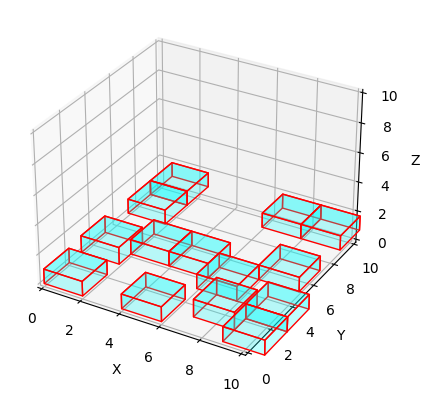

In [13]:
obs = env.reset()
while True:
# for _ in range(1000):
    action, _ = model_plotratio.predict(obs)
    
    obs, _, done, _ = env.step(action)
    #reshpare a list to np.array (10x10)
    if done:

        print(np.array(obs[:100]).reshape(10,10))
        print('boxes placed:\n ',env.boxes)
        # obs = env.reset()
        print('done')
        break

env.render()

Test4 Generate Buildings within Site Boundary Area

In [14]:
sting = '103.9184733 1.3092462, 103.9185355 1.3092515, 103.9185338 1.3092714, 103.9186415 1.3092804, 103.9186431 1.3092613, 103.9187158 1.3092674, 103.9187202 1.3092156, 103.9187321 1.3092166, 103.9187379 1.3091466, 103.9186642 1.3091404, 103.9186697 1.3090749, 103.9187467 1.3090814, 103.9187526 1.3090106, 103.9187395 1.3090095, 103.9187444 1.3089509, 103.9186749 1.3089451, 103.9186763 1.3089285, 103.9185696 1.3089195, 103.9185683 1.3089349, 103.9185011 1.3089292, 103.9184967 1.3089811, 103.9184756 1.3089793, 103.9184691 1.3090564, 103.918545 1.3090628, 103.9185392 1.3091312, 103.9184654 1.3091249, 103.9184593 1.3091968, 103.9184773 1.3091984, 103.9184733 1.3092462'
#replace "' "with ","
sting = sting.replace(", ",",")

string_list = sting.split(",")
# print(string_list)
string_list = ["("+ string_list[i].replace(" ",",") + ")" for i in range(len(string_list))]

string = "("+ ",".join(string_list) + ")"
print(string)


((103.9184733,1.3092462),(103.9185355,1.3092515),(103.9185338,1.3092714),(103.9186415,1.3092804),(103.9186431,1.3092613),(103.9187158,1.3092674),(103.9187202,1.3092156),(103.9187321,1.3092166),(103.9187379,1.3091466),(103.9186642,1.3091404),(103.9186697,1.3090749),(103.9187467,1.3090814),(103.9187526,1.3090106),(103.9187395,1.3090095),(103.9187444,1.3089509),(103.9186749,1.3089451),(103.9186763,1.3089285),(103.9185696,1.3089195),(103.9185683,1.3089349),(103.9185011,1.3089292),(103.9184967,1.3089811),(103.9184756,1.3089793),(103.9184691,1.3090564),(103.918545,1.3090628),(103.9185392,1.3091312),(103.9184654,1.3091249),(103.9184593,1.3091968),(103.9184773,1.3091984),(103.9184733,1.3092462))


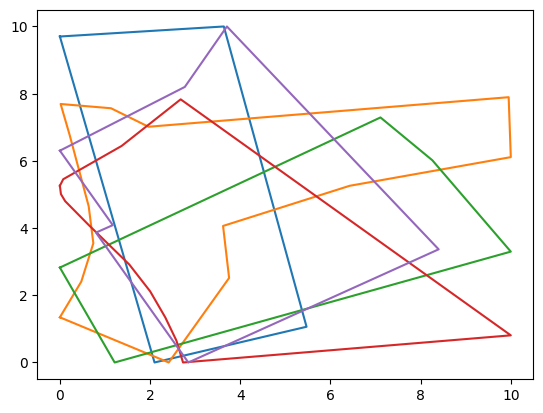

In [15]:
sites_list = [Polygon(((103.9367259,1.3143551),(103.9370357,1.3129232),(103.9375333,1.3130801),(103.9372625,1.3143992),(103.9367259,1.3143551))),
              Polygon(((103.8272847,1.2843737),(103.8277838,1.2840957),(103.8280608,1.2846159),(103.8280331,1.2849361),(103.8286137,1.2851832),(103.8293528,1.2853596),(103.829343,1.2857285),(103.8276913,1.2855466),(103.827519,1.2856605),(103.8272881,1.2856867),(103.8273295,1.2854956),(103.8274168,1.2850571),(103.8274381,1.2848296),(103.8273828,1.2845934),(103.8272847,1.2843737))),
            Polygon(((103.9502369,1.3283904),(103.9505232,1.3277247),(103.9525938,1.3285024),(103.9521837,1.3291431),(103.9519125,1.3294435),(103.9502369,1.3283904))),
             Polygon(((103.9347477,1.3384172),(103.9347544,1.3383448),(103.9347819,1.3382832),(103.9349328,1.338078),(103.935199,1.3377301),(103.9353338,1.3374975),(103.9354324,1.3372696),(103.9355048,1.3370671),(103.9355476,1.3368769),(103.9376767,1.3371135),(103.9355323,1.3391707),(103.9351487,1.3387645),(103.9347692,1.3384742),(103.9347477,1.3384172))),
             Polygon(((103.9544223,1.3204243),(103.9545532,1.3201771),(103.9545116,1.3201523),(103.9547401,1.3197211),(103.9553594,1.3200968),(103.9548355,1.3208367),(103.9547314,1.320636),(103.9544223,1.3204243)))]#plot pologon

def resize_polygon(site,desired_scale  =10):
    X,Y = site.exterior.xy
    # scale x,y so that it is between 0to 10 range 

    # Calculate the scale factor to fit the polygon within a specific range
    current_width = max(X) - min(X)
    current_height = max(Y) - min(Y)

    longest_axis = max(current_width, current_height)
    scale_factor = desired_scale /longest_axis


    # Scale the polygon coordinates
    scaled_polygon_x = [(x- min(X)) * scale_factor  for x in X]
    scaled_polygon_y = [(y-min(Y)) * scale_factor  for y in Y]

    return scaled_polygon_x, scaled_polygon_y

fig, ax = plt.subplots()
for site in sites_list:
    X,Y = resize_polygon(site)

    ax.plot(X,Y)

plt.show()


In [18]:
import gym
from gym import spaces
import numpy as np
import math
from shapely.geometry import Polygon, Point
import random


class ContinuousBoxPlacementEnv(gym.Env):
    def __init__(self,sites_list, grid_size=(10, 10), max_boxes=100, plot_ratio= 0.3):
        super(ContinuousBoxPlacementEnv, self).__init__()
        self.grid_size = grid_size
        self.grid= np.zeros(self.grid_size, dtype=int)
        self.max_boxes = max_boxes
        self.plot_ratio = plot_ratio
        self.sites_list = sites_list
        self.site_boundary = self._generate_site(self.sites_list)
        self.building_list = [Polygon(((103.9182582,1.3085852),(103.9183205,1.3085905),(103.9183188,1.3086104),(103.9184265,1.3086194),(103.9184281,1.3086003),(103.9185008,1.3086064),(103.9185052,1.3085546),(103.918517,1.3085556),(103.9185229,1.3084856),(103.9184491,1.3084794),(103.9184547,1.3084139),(103.9185317,1.3084204),(103.9185376,1.3083497),(103.9185245,1.3083486),(103.9185294,1.30829),(103.9184599,1.3082841),(103.9184613,1.3082676),(103.9183545,1.3082586),(103.9183532,1.3082739),(103.9182861,1.3082683),(103.9182817,1.3083201),(103.9182606,1.3083183),(103.9182541,1.3083954),(103.91833,1.3084018),(103.9183242,1.3084702),(103.9182504,1.308464),(103.9182443,1.3085359),(103.9182623,1.3085374),(103.9182582,1.3085852))),
                              Polygon(((103.9180943,1.309182),(103.9182393,1.3091933),(103.9182464,1.3091028),(103.9182956,1.3091066),(103.9183064,1.308967),(103.9181121,1.3089519),(103.9180943,1.309182))),
                              Polygon(((103.9184733,1.3092462),(103.9185355,1.3092515),(103.9185338,1.3092714),(103.9186415,1.3092804),(103.9186431,1.3092613),(103.9187158,1.3092674),(103.9187202,1.3092156),(103.9187321,1.3092166),(103.9187379,1.3091466),(103.9186642,1.3091404),(103.9186697,1.3090749),(103.9187467,1.3090814),(103.9187526,1.3090106),(103.9187395,1.3090095),(103.9187444,1.3089509),(103.9186749,1.3089451),(103.9186763,1.3089285),(103.9185696,1.3089195),(103.9185683,1.3089349),(103.9185011,1.3089292),(103.9184967,1.3089811),(103.9184756,1.3089793),(103.9184691,1.3090564),(103.918545,1.3090628),(103.9185392,1.3091312),(103.9184654,1.3091249),(103.9184593,1.3091968),(103.9184773,1.3091984),(103.9184733,1.3092462)))]

        # Define the action space for continuous placement (x, y, length, width, height)
        self.action_space = spaces.Box(low=np.array([0,0,2,2,1]), high=np.array([1,1,5,5,9]), shape=(5,))

        # Define the state space to represent the current box positions and sizes
        self.observation_space = spaces.MultiBinary(np.prod(grid_size) + max_boxes )

        self.boxes_placed = 0
        self.boxes = np.zeros((1,5), dtype=float)
        self.state = self._get_state()

    def reset(self):
        self.boxes_placed = 0
        self.site_boundary = self._generate_site(self.sites_list)
        self.boxes = np.zeros((1,5), dtype=float)
        self.state = self._get_state()
        self.grid = np.zeros(self.grid_size)
        flat_grid = self.grid.flatten()
        box_count = np.zeros(self.max_boxes)
        self.state = np.concatenate([flat_grid, box_count])
        return self.state

    def step(self, action):
        # Execute an action (place a box) and return the next state, reward, and done flag
        if self.boxes_placed >= self.max_boxes:
            return self.state, 0, True, {}
        
        if not self._is_valid_plot_ratio():
            return self.state, -1, True, {}
        
        

        x, y, length, width, height = action
        x, y, length, width, height  = math.floor(x*9.8), math.floor(y*9.8), length, width, height

        if not self.site_boundary.contains(Point(x,y)):
            return self.state, -1, False, {}

        if not self._is_valid_placement(x, y, length, width, height):
            return self.state, -1, False, {}

        # self.boxes[self.boxes_placed] = [x, y, length, width, height]
        self.boxes = np.append(self.boxes, np.array([[x, y, length, width, height]]), axis=0)
        self.boxes_placed += 1
        self.grid[x,y] = 1 
        self.state = self._get_state()

        reward = 1

        done = self.boxes_placed >= self.max_boxes

        return self.state, reward, done, {}

    def _is_valid_placement(self, x, y, length, width, height):
        # Check if the placement is valid (no intersection with other boxes)
        
        for i in range(self.boxes_placed):
            box = self.boxes[i]
            if (x < box[0] + box[2] and x + length > box[0] and
                y < box[1] + box[3] and y + width > box[1]):
                # print(box, ' compare with')
                # print(x,y,length,width,height)
                return False

        return True
    
   
    def _resize_polygon(self, site, desired_scale=10, center=None):
        X, Y = site.exterior.xy
        # print(site.exterior.xy)

        # Calculate the center of the polygon if a custom center is not provided
        

        # Calculate the scale factor to fit the polygon within a specific range
        current_width = max(X) - min(X)
        current_height = max(Y) - min(Y)
        # print(current_width, current_height)
        longest_axis = max(current_width, current_height)
        scale_factor = desired_scale / longest_axis

        if center is None:
            center_x = current_width / 2
            center_y = current_height / 2
        else:
            center_x, center_y = center

        # Scale and center the polygon coordinates
        scaled_polygon_x = [(x - min(X)) * scale_factor + center_x for x in X]
        scaled_polygon_y = [(y - min(Y)) * scale_factor + center_y for y in Y]

        return scaled_polygon_x, scaled_polygon_y


    def _get_state(self):
        flat_grid = self.grid.flatten()
        
        box_count = np.zeros(self.max_boxes)
        box_count[:self.boxes_placed] = 1
        return np.concatenate([flat_grid, box_count])
    
    def _is_valid_plot_ratio(self):
        total_footprint = 0
        for i in range(self.boxes_placed):
            box = self.boxes[i]
            box_footprint = box[2] * box[3]
            total_footprint += box_footprint
        
        if (total_footprint/self.site_boundary.area > self.plot_ratio):
            # print('total_footprint > plot_ratio: ', total_footprint/np.prod(self.grid_size))
            return False
        
        return True
    
    def _generate_site(self,sites_list):
        site = sites_list[random.randint(0,len(sites_list)-1)]
        x,y =  self._resize_polygon(site)
        return Polygon(list(zip(x, y)))
    
    def render(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Create vertices for the building
        for i in range(len(self.boxes)):
            x = self.boxes[i][0]
            y = self.boxes[i][1]
            length = self.boxes[i][2]
            width = self.boxes[i][3]
            height = self.boxes[i][4]
            building = self._generate_site(self.building_list)

            polygon_x, polygon_y = building.exterior.xy

            #scale x,y to range [0,1]
            # polygon_x, polygon_y = 
            
            # vertices = np.vstack([scaled_polygon, scaled_polygon + [0, 0, height]])
            # print(vertices)
            building_polygon = Polygon(((103.9370357, 1.3143551),
            (103.9370357, 1.3129232),
            (103.9372625, 1.3129232),
            (103.9372625, 1.3134300),
            (103.9375333, 1.3134300),
            (103.9375333, 1.3129232),
            (103.9377601, 1.3129232),
            (103.9377601, 1.3143551),
            (103.9375333, 1.3143551),
            (103.9375333, 1.3139200),
            (103.9372625, 1.3139200),
            (103.9372625, 1.3143551),
            (103.9370357, 1.3143551)
        ))

            polygon_coords_2d = self._resize_polygon(building_polygon,length,(x,y))
            # print((x,y))

            polygon_coords_2d = list(zip(polygon_coords_2d[0], polygon_coords_2d[1]))

            
            polygon_coords_3d = [(x, y, 0) for x, y in polygon_coords_2d]  # Bottom face
            polygon_coords_3d_top = [(x, y, height) for x, y in polygon_coords_2d]  # Top face

            # Create the polygon faces
            verts = [polygon_coords_3d, polygon_coords_3d_top]

            # Plot the 3D polygon
            poly3d = [[verts[0][i], verts[0][i + 1], verts[1][i + 1], verts[1][i]] for i in range(len(verts[0]) - 1)]

            # Define faces of the building
            # faces = [
            #     [vertices[0], vertices[1], vertices[5], vertices[4]],
            #     [vertices[7], vertices[6], vertices[2], vertices[3]],
            #     [vertices[0], vertices[4], vertices[7], vertices[3]],
            #     [vertices[1], vertices[5], vertices[6], vertices[2]],
            #     [vertices[4], vertices[5], vertices[6], vertices[7]]
            # ]

            # Plot the building
            ax.add_collection3d(Poly3DCollection(poly3d, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.5))


            vertices = np.array([
                [x, y, 0],
                [x, y + width, 0],
                [x + length, y + width, 0],
                [x + length, y, 0],
                [x, y, height],
                [x, y + width, height],
                [x + length, y + width, height],
                [x + length, y, height]
            ])
            

            # Define faces of the building
            faces = [
                [vertices[0], vertices[1], vertices[5], vertices[4]],
                [vertices[7], vertices[6], vertices[2], vertices[3]],
                [vertices[0], vertices[4], vertices[7], vertices[3]],
                [vertices[1], vertices[5], vertices[6], vertices[2]],
                [vertices[4], vertices[5], vertices[6], vertices[7]]
            ]

            # Plot the building
            # ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

            # Set axis labels
            ax.plot(list(self.site_boundary.exterior.xy[0]),list(self.site_boundary.exterior.xy[1])  , alpha=0.5)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')

        # Set plot limits
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 10])
        ax.set_zlim([0, 10])

        # Display the plot
        plt.show()

        

# Example usage:
env = ContinuousBoxPlacementEnv(sites_list)
obs = env.reset()

# Sample action: (x, y, length, width, height)
action = np.array([0.5, 0.4, 0.3, 0.2, 0.1])
obs, reward, done, _ = env.step(action)
print("Next state (box placement):")
# print(env.site_boundary)


Next state (box placement):


In [19]:
model_siteboundary = PPO('MlpPolicy', env, verbose=1)
# Train the agent
model_siteboundary.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99.5     |
|    ep_rew_mean     | -91.3    |
| time/              |          |
|    fps             | 7208     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 85.3       |
|    ep_rew_mean          | -77        |
| time/                   |            |
|    fps                  | 4399       |
|    iterations           | 2          |
|    time_elapsed         | 0          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00736913 |
|    clip_fraction        | 0.0505     |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.05      |
|    explained_variance   | -0.022     |
|    learning_rate        | 0.0003     |
|   

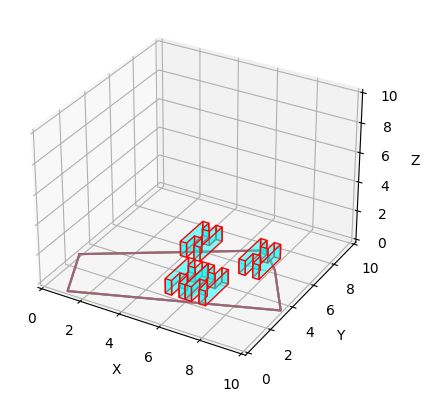

In [39]:
obs = env.reset()
while True:
# for _ in range(1000):
    action, _ = model_siteboundary.predict(obs)
    
    obs, _, done, _ = env.step(action)
    #reshpare a list to np.array (10x10)
    if done:

        # print(np.array(obs[:100]).reshape(10,10))
        # print('boxes placed:\n ',env.boxes)
        # obs = env.reset()
        # print('done')
        break

env.render()

In [272]:
list(env.site_boundary.exterior.xy)

[array('d', [0.0, 1.1733596271246944, 0.8004661168793675, 2.848691287115165, 8.399964144868141, 3.7038365005106293, 2.7707063463201953, 0.0]),
 array('d', [6.3033345285043785, 4.087486554320266, 3.8651846539971695, 0.0, 3.3676945141622743, 10.0, 8.200968088919455, 6.3033345285043785])]